In [25]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import mean_squared_error
import math
from statistics import mean
import datetime as dt
import numpy as np
from bokeh.plotting import show
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn import tree 

import seaborn as sns
sns.set_style("ticks")
sns.set_context("notebook", rc={"lines.linewidth": 2})

import statistics as stat
import random
import matplotlib.pyplot as plt
from sklearn import tree 
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix

pd.set_option("display.max_columns", None)

# <span style='color:green'> [done] </span> Loading data frames:

## <span style='color:green'> [done] </span> Load fighters data_frame:

In [29]:
loc = 'data/'
file = 'ufc_fighters_stats_processed.csv'
stats = pd.read_csv(loc+file)
stats = stats[stats.columns[1:]]
print('Data Frame loaded: '+str(stats.shape))
stats.tail(3)

Data Frame loaded: (11198, 17)


,name,wins,losses,draws,height,weight,reach,stance,age,slpm,str. acc.,sapm,str. def,td avg.,td acc.,td def.,sub. avg.
11195,Carlos Zevallos,3,0.0,-0,182.88,92.25,187.37,Orthodox,37.31,4.36,0.65,2.28,0.68,0.0,0.0,1.00,0.0
11196,Zach Zane,10,7.0,0,170.18,65.25,175.26,Southpaw,33.00,0.87,0.56,6.67,0.20,0.0,0.0,0.26,0.0
11197,Roger Zapata,4,0.0,-0,180.34,76.50,184.77,Southpaw,36.00,2.60,0.51,2.13,0.36,0.0,0.0,0.81,1.4


In [30]:
def get_fighters_stats(fighter, opponent, data=stats):
    import pandas as pd
    data1 = pd.DataFrame((data[data.name == fighter]).reset_index(drop=True).loc[0])[1:].rename(columns={0:fighter})
    data2 = pd.DataFrame((data[data.name == opponent]).reset_index(drop=True).loc[0])[1:].rename(columns={0:opponent})
    return pd.concat([data1,data2], axis=1)

## <span style='color:green'> [done] </span> Prepare main data_frame:

In [41]:
loc = "data/"
file = 'ufc_data_features.csv'
df = pd.read_csv(loc+file)
df = df[df.columns[1:]]
df.date = pd.to_datetime(df.date)
print('Data Frame loaded: '+str(df.shape))
df.tail(3)

Data Frame loaded: (6731, 22)


,result,fighter,opponent,date,weight class,method,kd_dif,str_dif,td_dif,sub_dif,td avg._dif,td acc._dif,td def._dif,sub. avg._dif,slpm_dif,str. acc._dif,sapm_dif,str. def_dif,stance_win_ratio,win_perc_dif,win_strk_dif,lose_strk_dif
6728,win,Aleksandra Albu,Kailin Curran,2017-07-29,Women's Strawweight,U-DEC:,0.011068,-0.152692,1.561141,0.025311,0.143460,-0.226539,0.513489,-0.183840,0.598081,0.314077,0.492188,-1.248810,0.080165,2.035072,0.573609,-2.148188
6729,win,Jarred Brooks,Eric Shelton,2017-07-29,Flyweight,S-DEC:,0.011068,-0.152692,1.561141,0.025311,0.946272,0.228144,0.748089,0.388205,-0.281189,0.314077,-0.136626,-0.071265,1.068316,-0.009111,0.001615,-1.070893
6730,lose,Joshua Burkman,Drew Dober,2017-07-29,Lightweight,KO/TKO:Punch,-1.343474,-0.152692,-0.018065,0.025311,0.985298,0.682827,0.580517,0.197523,-1.122504,0.232995,-0.631131,0.012846,-1.769806,-0.136872,0.001615,2.160992


## <span style='color:green'> [done] </span> Clean Outliers:

In [43]:
original_size = len(df)
X = df.columns[10:len(df.columns)]

for feature in X:
    df = df[df[feature] <= 3]
    
print('Rows deleted: %d' %(original_size-len(df)))

Rows deleted: 389


In [6]:
df = (df[['date','result','fighter','opponent','win_perc_dif','win_strk_dif','lose_strk_dif','td avg._dif','sub. avg._dif','sapm_dif','slpm_dif','kd_dif','str_dif','td_dif','sub_dif']]).copy()
df = df.dropna().reset_index(drop=True)
print('Columns sorted:')
df.tail(3)

Columns sorted:


,date,result,fighter,opponent,win_perc_dif,win_strk_dif,lose_strk_dif,td avg._dif,sub. avg._dif,sapm_dif,slpm_dif,kd_dif,str_dif,td_dif,sub_dif
6422,2017-07-29,win,Aleksandra Albu,Kailin Curran,2.035072,0.573609,-2.148188,0.143460,-0.183840,0.492188,0.598081,0.011068,-0.152692,1.561141,0.025311
6423,2017-07-29,win,Jarred Brooks,Eric Shelton,-0.009111,0.001615,-1.070893,0.946272,0.388205,-0.136626,-0.281189,0.011068,-0.152692,1.561141,0.025311
6424,2017-07-29,lose,Joshua Burkman,Drew Dober,-0.136872,0.001615,2.160992,0.985298,0.197523,-0.631131,-1.122504,-1.343474,-0.152692,-0.018065,0.025311


In [44]:
X_columns = X
y = ['kd_dif','str_dif','td_dif','sub_dif']

# <span style='color:green'> [done] </span> Predicting Fight statistics Func:

In [45]:
def set_train_test(X_columns=X_columns, y_columns=y, data=df, test_size=0.3, valid_size=0.1):

    if 'set' not in data.columns:
        data.insert(0, 'set', None) # inserd 'set' column to position 0
    
    for i in range(len(df)):
        
        if data.loc[i,'result'] == None:
            data.loc[i,'set'] = 'new'
        
        elif random.random() < test_size:
            data.loc[i,'set'] = 'test'
        else:
            if random.random() < valid_size:
                data.loc[i,'set'] = 'validation'
            else:
                data.loc[i,'set'] = 'train' 

    X_train = data[X_columns][data.set=='train'] 
    X_test = data[X_columns][data.set=='test']
    y_train = data[y_columns][data.set=='train']
    y_test = data[y_columns][data.set=='test']
    X_val = data[X_columns][data.set=='validation']
    y_val = data[y_columns][data.set=='validation']

    print('Data split: Data=%s, train_set=%s, validation_set=%s, test_set=%s'  %(str(data.shape), str(X_train.shape), str(X_val.shape), str(X_test.shape)))
    return data

In [46]:
def set_knn_reg(X_columns=X_columns, y_columns=y, data=df, n=200):
    
    from sklearn.neighbors import KNeighborsRegressor
    
    knn_reg=KNeighborsRegressor(n_neighbors=n, algorithm='ball_tree')
    X_train = data[X_columns][data.set=='train']
    y_train = data[y_columns][data.set=='train']
    knn_reg.fit(X_train,y_train)
    return knn_reg

In [50]:
def set_predictions(model, data=df, X_columns=X_columns, y_columns=y):

    for column in y_columns:
        data[column + '_pred'] = None
        data[column + '_pred'] = model.predict(data[X_columns])    
    
    return data

In [51]:
def get_rmse(act, pred):
    
    from sklearn.metrics import mean_squared_error
    import math
    return round(math.sqrt(mean_squared_error(act, pred))/(np.max(act) - np.min(act)),4)

# <span style='color:green'> [done] </span> Predicting Final Outcome Func

In [52]:
def set_forest_clf(X_columns, y_columns, n_estimators, tree_depth, data):
    
    from sklearn.ensemble import RandomForestClassifier
    forest_clf = RandomForestClassifier(max_depth=tree_depth, random_state=1, n_estimators=n_estimators)
    
    X_train = data[X_columns][data.set=='train']
    y_train = data[y_columns][data.set=='train']
    forest_clf.fit(X_train,y_train)
    
    return forest_clf

# <span style='color:green'> [done] </span> Set new fight:

In [53]:
def set_new_fight(fighter, opponent, data=df):
    
    row = {'date': get_current_date(),
           'result': None,
           'fighter': fighter,
           'opponent': opponent,
           'win_perc_dif': get_win_perc(fighter=fighter, data=data) - get_win_perc(fighter=opponent, data=data),
           'win_strk_dif': get_win_streak(fighter=fighter, data=data) - get_win_streak(fighter=opponent, data=data),
           'lose_strk_dif': get_lose_streak(fighter=fighter, data=data) - get_lose_streak(fighter=opponent, data=data),
           'td avg._dif': get_td_avg(fighter=fighter, data=stats) - get_td_avg(fighter=opponent, data=stats),
           'sub. avg._dif': get_sub_avg(fighter=fighter, data=stats) - get_sub_avg(fighter=opponent, data=stats),
           'sapm_dif': get_sapm(fighter=fighter, data=stats) - get_sapm(fighter=opponent, data=stats),
           'slpm_dif': get_slpm(fighter=fighter, data=stats) - get_slpm(fighter=opponent, data=stats),
           'kd_dif':None,
           'str_dif':None,
           'td_dif':None,
           'sub_dif':None,
          }
    return pd.DataFrame(row, index=[0])

In [54]:
def get_current_date():
    from datetime import date
    import pandas as pd
    return pd.to_datetime(date.today())

def get_win_perc(fighter, data=df):
    '''return current career winning %'''
    date = get_current_date()
    wins = len(data[(data['fighter'] == fighter)&(data.date < date) & (data['result']=='win')]) + len(data[(data['opponent'] == fighter)&(data.date < date) & (data['result']=='lose')])
    losses = len(data[(data['fighter'] == fighter)&(data.date < date) & (data['result']=='lose')]) + len(data[(data['opponent'] == fighter)&(data.date < date) & (data['result']=='win')])
    
    if wins == 0:
        return 0
    return wins/(wins+losses)

def get_lose_streak(fighter, data=df):
    '''return current lose streak'''
    date = get_current_date()
    data = ((data[(data.date < date)&((data.fighter == fighter)|(data.opponent == fighter))]).sort_values(by=['date'], ascending=False)).reset_index(drop=True)
    
    count = 0
    for i in range(0,len(data)):
        
        result = data.loc[i,'result']
        f = data.loc[i,'fighter']
        o = data.loc[i,'opponent']
        
        if ((result == 'lose')&(f == fighter))|((result == 'win')&(o == fighter)):
            count += 1
        else:
            return count
    return count

def get_win_streak(fighter, data=df):
    '''return current win streak'''
    date = get_current_date()
    data = ((data[(data.date < date)&((data.fighter == fighter)|(data.opponent == fighter))]).sort_values(by=['date'], ascending=False)).reset_index(drop=True)
    
    count = 0
    for i in range(0,len(data)):
        
        result = data.loc[i,'result']
        f = data.loc[i,'fighter']
        o = data.loc[i,'opponent']
        
        if ((result == 'win')&(f == fighter))|((result == 'lose')&(o == fighter)):
            count += 1
        else:
            return count
    return count

def get_td_avg(fighter, data=stats):
    '''return current takedown average'''
    data = (data[data.name == fighter]).reset_index(drop=True)
    return data.loc[0,'td avg.']

def get_sub_avg(fighter, data=stats):
    '''return current submission average'''
    data = (data[data.name == fighter]).reset_index(drop=True)
    return data.loc[0,'sub. avg.']

def get_sapm(fighter, data=stats):
    '''return current strikes absorbed per minute'''
    data = (data[data.name == fighter]).reset_index(drop=True)
    return data.loc[0,'sapm']

def get_slpm(fighter, data=stats):
    '''return current strikes landed per minutes'''
    data = (data[data.name == fighter]).reset_index(drop=True)
    return data.loc[0,'slpm']

# <span style='color:green'> **[done]** </span> Main():

In [62]:
X_columns = ['sapm_dif','slpm_dif','win_perc_dif','win_strk_dif','lose_strk_dif','td avg._dif','sub. avg._dif']
y = ['kd_dif','str_dif','td_dif','sub_dif']

## <span style='color:green'> **[done]** </span> Pick a Fight: inserd Fighter & Opponent

In [61]:
df[df.isna()]

,set,result,fighter,opponent,date,weight class,method,kd_dif,str_dif,td_dif,sub_dif,td avg._dif,td acc._dif,td def._dif,sub. avg._dif,slpm_dif,str. acc._dif,sapm_dif,str. def_dif,stance_win_ratio,win_perc_dif,win_strk_dif,lose_strk_dif,kd_dif_pred
0,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6338,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6339,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6340,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6341,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [63]:
fighter = 'Natan Levy'
opponent = 'Genaro Valdez'
df = pd.concat([df,set_new_fight(fighter=fighter, opponent=opponent, data=df)], ignore_index=True)
df.tail(1)

,set,result,fighter,opponent,date,weight class,method,kd_dif,str_dif,td_dif,sub_dif,td avg._dif,td acc._dif,td def._dif,sub. avg._dif,slpm_dif,str. acc._dif,sapm_dif,str. def_dif,stance_win_ratio,win_perc_dif,win_strk_dif,lose_strk_dif,kd_dif_pred
6343,NaN,None,Natan Levy,Genaro Valdez,2022-12-07,NaN,NaN,NaN,NaN,NaN,NaN,-1.55,NaN,NaN,-1.0,-1.28,NaN,-9.29,NaN,NaN,0.5,1.0,-1.0,NaN


### <span style='color:green'> **[done]** </span> Predict fight stats:

In [59]:
df = set_train_test(X_columns=X_columns, y_columns=y, data=df, test_size=0.3, valid_size=0.1)
knn_reg = set_knn_reg(X_columns=X_columns, y_columns=y, data=df, n=200)
df = set_predictions(model=knn_reg, data=df, X_columns=X_columns, y_columns=y)
knn_reg

Data split: Data=(6343, 24), train_set=(4054, 12), validation_set=(439, 12), test_set=(1849, 12)


ValueError: Input X contains NaN.
KNeighborsRegressor does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [18]:
df.tail(1)

,set,date,result,fighter,opponent,win_perc_dif,win_strk_dif,lose_strk_dif,td avg._dif,sub. avg._dif,sapm_dif,slpm_dif,kd_dif,str_dif,td_dif,sub_dif,kd_dif_pred,str_dif_pred,td_dif_pred,sub_dif_pred
6425,new,2022-12-07,None,Natan Levy,Genaro Valdez,0.5,1.0,-1.0,-1.55,-1.0,-9.29,-1.28,None,None,None,None,0.143136,0.143136,0.143136,0.143136


### <span style='color:green'> **[done]** </span> Predict Winner:

In [19]:
def set_forest_clf(X_columns, y_columns, n_estimators, tree_depth, data):
    
    from sklearn.ensemble import RandomForestClassifier
    forest_clf = RandomForestClassifier(max_depth=tree_depth, random_state=1, n_estimators=n_estimators)
    
    X_train = data[X_columns][data.set=='train']
    y_train = data[y_columns][data.set=='train']
    forest_clf.fit(X_train,y_train)
    
    return forest_clf

In [20]:
def get_accuracy(act, pred):
    
    from sklearn.metrics import accuracy_score
    return accuracy_score(act, pred)

In [21]:
def get_winner(fighter=fighter, opponent=opponent, data=df):
    '''return winner of the fight'''
    winner = None
    data = (data[(data['fighter'] == fighter) & (data['opponent'] == opponent)]).reset_index(drop=True)
    
    if data.loc[0,'result_pred'] == 'win':
        winner = fighter
    else: 
        winner = opponent    
    
    return winner

In [22]:
X_columns = ['win_perc_dif', 'win_strk_dif', 'lose_strk_dif', 'td avg._dif',
             'sub. avg._dif', 'sapm_dif', 'slpm_dif','sub_dif_pred',
             'kd_dif_pred', 'str_dif_pred', 'td_dif_pred']

#num_of_features = len(X_columns)
num_of_features = 3
y = 'result'
forest_clf = set_forest_clf(X_columns=X_columns, y_columns=y, data=df,tree_depth=num_of_features, n_estimators=50 )
df = set_predictions(model=forest_clf, data=df, X_columns=X_columns, y_columns=[y])
forest_clf

RandomForestClassifier(max_depth=3, n_estimators=50, random_state=1)

#### <span style='color:green'> **[done]** </span> Final Prediction:

In [23]:
print('--------------------------------------')
print('%s vs %s:' %(fighter, opponent))
print('--------------------------------------')
print(get_fighters_stats(fighter=fighter,opponent=opponent, data=stats))
print('--------------------------------------')
print('Winner: ' + get_winner())
print('Pridiction Accuracy: ' + str(get_accuracy(act=df['result'][df.set=='test'], pred=df['result_pred'][df.set=='test'])))
print('--------------------------------------')

--------------------------------------
Natan Levy vs Genaro Valdez:
--------------------------------------
          Natan Levy Genaro Valdez
wins               7            10
losses           0.0           1.0
draws             -0             0
height        175.26        175.26
weight         69.75         69.75
reach         180.34        182.88
stance      Southpaw      Orthodox
age             31.0          30.0
slpm            3.84          5.12
str. acc.       0.52          0.35
sapm            3.62         12.91
str. def        0.54          0.46
td avg.         5.13          6.68
td acc.         0.56          0.44
td def.         0.41           0.0
sub. avg.        0.7           1.7
--------------------------------------
Winner: Natan Levy
Pridiction Accuracy: 0.6120162932790224
--------------------------------------


### <span style='color:green'> **[done]** </span> Evaluation Report:

Accuracy = 0.612016


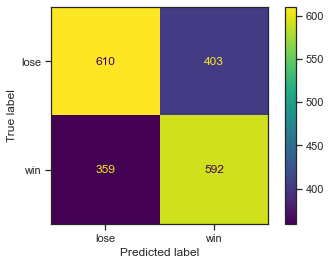

In [24]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

y_test_act = df['result'][df.set=='test']
y_test_pred = df['result_pred'][df.set=='test']

print('Accuracy = %.6f' % accuracy_score(y_test_act,y_test_pred))
ConfusionMatrixDisplay.from_predictions(y_test_act,y_test_pred)  